In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import math
from tqdm import tqdm
import time as time
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import large_scale_UQ as luq
from convex_reg import utils as utils_cvx_reg

# Select GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
1
0
NVIDIA A100-PCIE-40GB


In [2]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}

In [3]:

### set seed
torch.manual_seed(0)

device = 'cuda:0'
torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 25
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name + exp_name, device, device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L = model.L.data.item()
print(f"Lipschitz bound {L:.3f}")

im = torch.empty((1, 1, 100, 100), device=device).uniform_()
grad = model.grad(im)# alias for model.forward(im) and hence model(im)

im = torch.empty((1, 1, 100, 100), device=device).uniform_()
cost = model.cost(100*im)

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 1.479
-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


In [4]:

example_img_dir = '/disk/xray0/tl3/repos/convex_ridge_regularizers/image/'
img = cv2.resize(cv2.imread(example_img_dir + 'sample.JPG', cv2.IMREAD_GRAYSCALE), (504, 378))
img = img[:377, :377]
img_torch = torch.tensor(img, device=device).reshape((1,1) + img.shape)/255



In [5]:
# try regularizer on a deblurring problem (using 5x5 uniform blur)
# first, setup the operators
A, AT, AAT_norm = luq.utils.blur_operators(
    [5,5],
    [img.shape[0],img.shape[1]],
    "uniform",
    device=device
)

In [6]:
# set the desired noise level and add noise to the burred image
sigma = 1/255.
sigma2 = sigma**2
img_torch_blurry = A(img_torch) + sigma * torch.randn_like(img_torch)

# Hyperparameters for the nn regularizer

# found by grid search below
#mu = 5.2
#lmbd = 1600
# computed with fixed mu, for mountain image
mu = 20
lmbd = 1405


# optimization settings
tol = 1e-4
n_iter_max = 1500

# stepsize rule
L = model.L 
alpha = 1./( 1. + mu * lmbd * L + AAT_norm/sigma2)

# initialization
# small x - optimization variable, large X sampling variable (see later)
x = torch.clone(img_torch_blurry)
z = torch.clone(img_torch_blurry)
t = 1

In [7]:
for i in tqdm(range(n_iter_max)):
    x_old = torch.clone(x)
    # added deblurring data term here
    x = z - alpha*(AT(A(z) - img_torch_blurry)/sigma2 + lmbd * model(mu * z))
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x + (t_old - 1)/t * (x - x_old)

    # relative change of norm for terminating
    res = (torch.norm(x_old - x)/torch.norm(x_old)).item()
    if res < tol:
        break


 14%|█▍        | 210/1500 [00:00<00:02, 479.96it/s]


In [8]:
#function handles to used for ULA
f = lambda _x: lmbd/mu * model.cost(mu * _x) + 0.5*torch.norm((A(_x) - img_torch_blurry))**2/sigma2
grad_f = lambda _x: AT(A(_x) - img_torch_blurry)/sigma2 + lmbd * model(mu * _x)

#ULA kernel
def ULA_kernel(_x, delta):
    return _x - delta * grad_f(_x) + math.sqrt(2*delta) * torch.randn_like(_x)


In [9]:
# Set up sampler
Lip_total = mu * lmbd * L + AAT_norm/sigma2

#step size for ULA
gamma = 1. / Lip_total

maxit = 20000
burnin = np.int64(maxit * 0.05)
n_samples = np.int64(100)
X = img_torch_blurry.clone()
MC_X = np.zeros((n_samples, X.shape[2], X.shape[3]))
thinned_trace_counter = 0
thinning_step = np.int64(maxit/n_samples)

psnr_values = []
ssim_values = []
logpi_eval = []


In [10]:

start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    X = ULA_kernel(X, gamma)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = luq.utils.welford(X)
        absfouriercoeff = luq.utils.welford(torch.fft.fft2(X).abs())
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        psnr_values.append(peak_signal_noise_ratio(current_mean, img_torch).item())
        ssim_values.append(structural_similarity_index_measure(current_mean, img_torch).item())
        logpi_eval.append(f(X).item())

        # collect thinned trace
        if np.mod(i_x,thinning_step) == 0:
            MC_X[thinned_trace_counter] = X.detach().cpu().numpy()
            thinned_trace_counter += 1

end_time = time.time()
elapsed = end_time - start_time    


100%|██████████| 20000/20000 [01:28<00:00, 225.35it/s]


In [11]:
current_mean = post_meanvar.get_mean()
current_var = post_meanvar.get_var().detach().cpu().squeeze()


In [12]:
x.max()

tensor(1.1578, device='cuda:0')

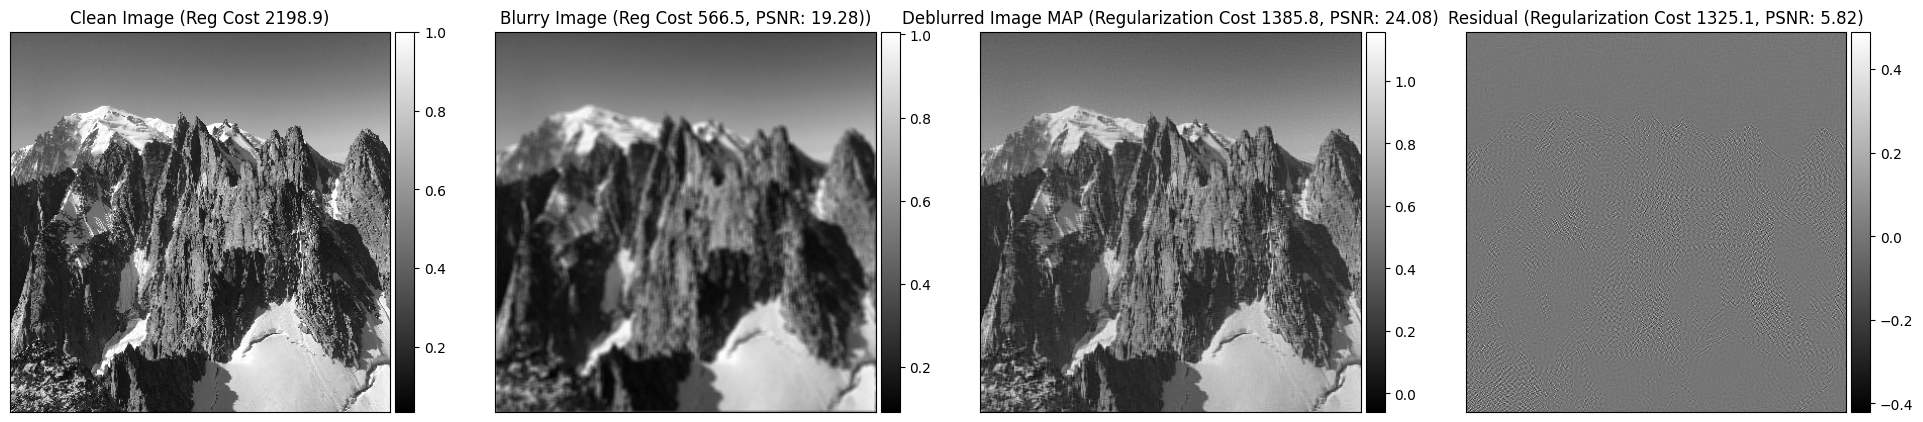

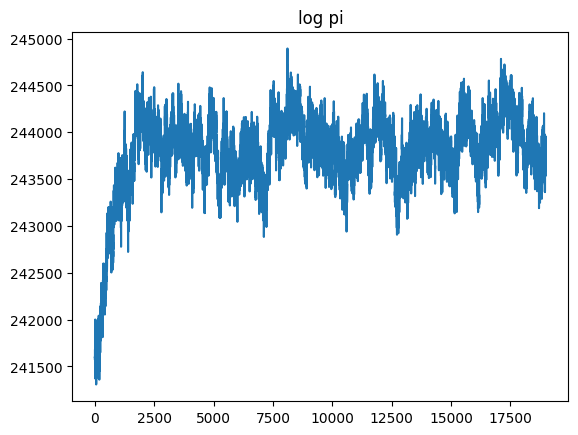

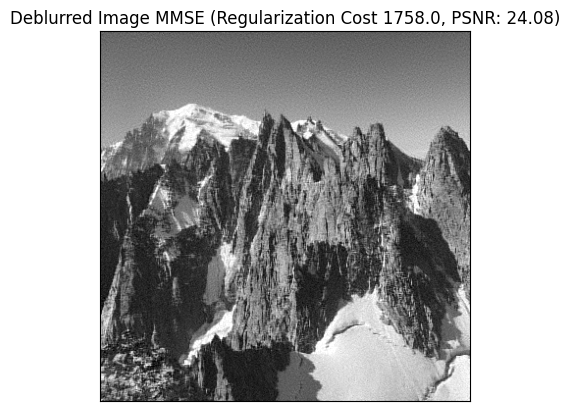

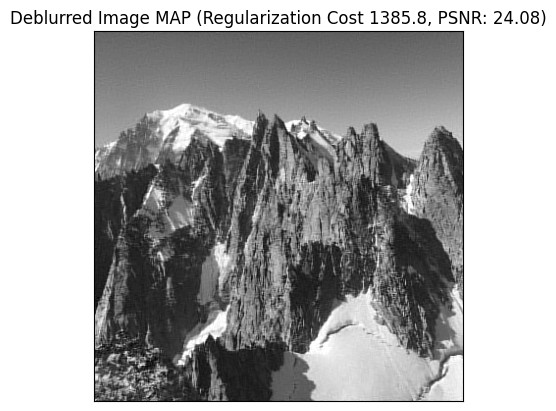

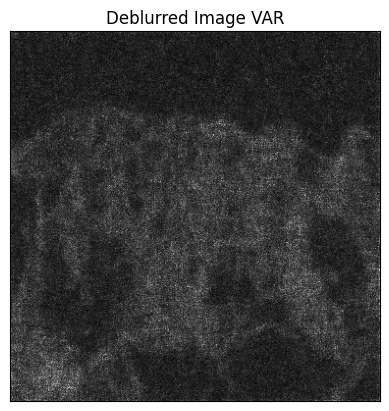

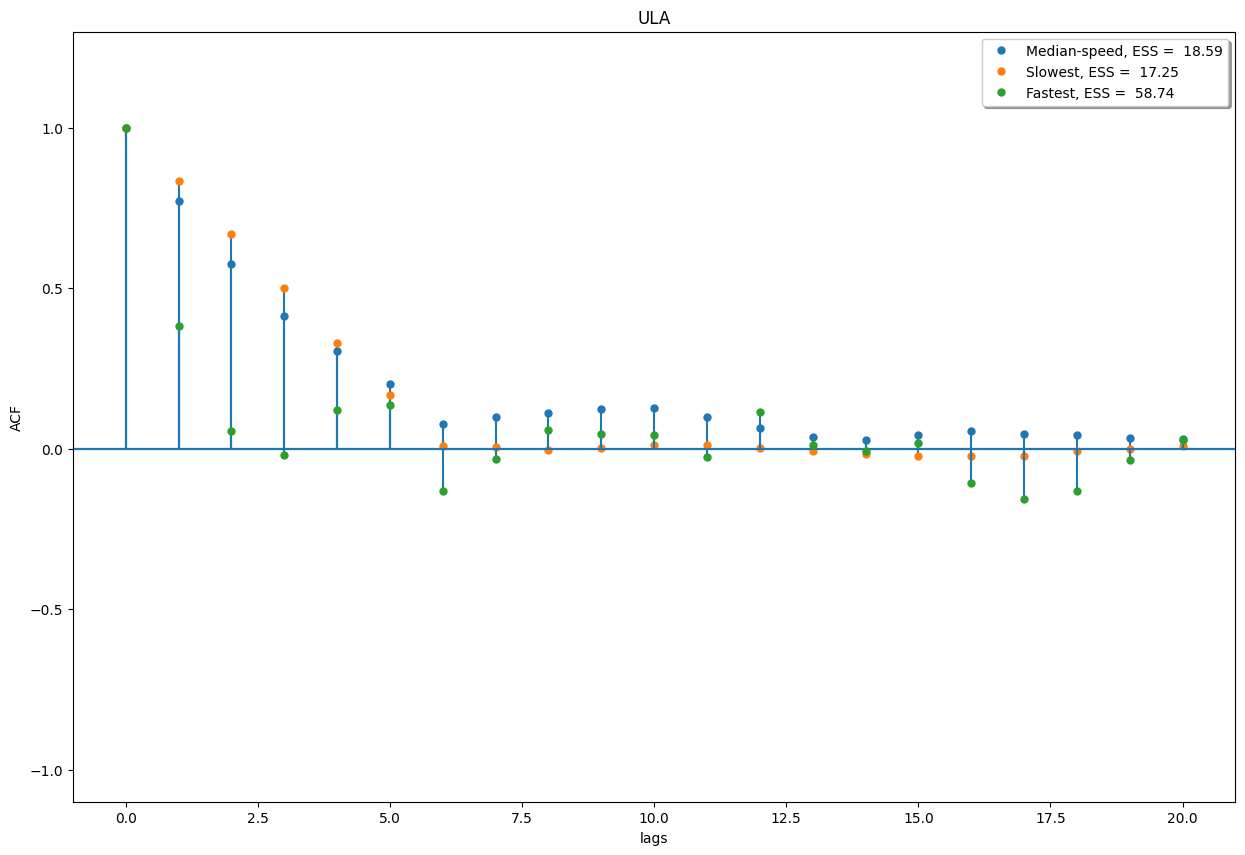

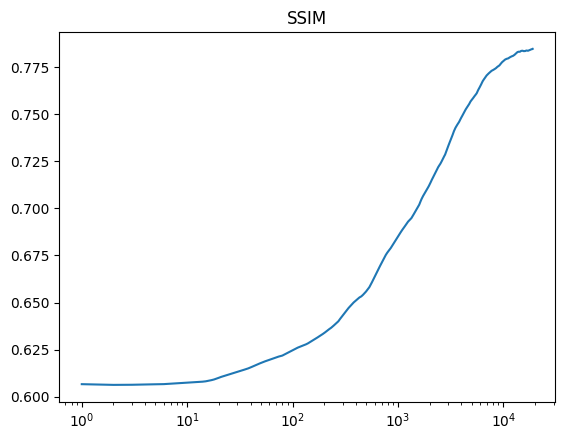

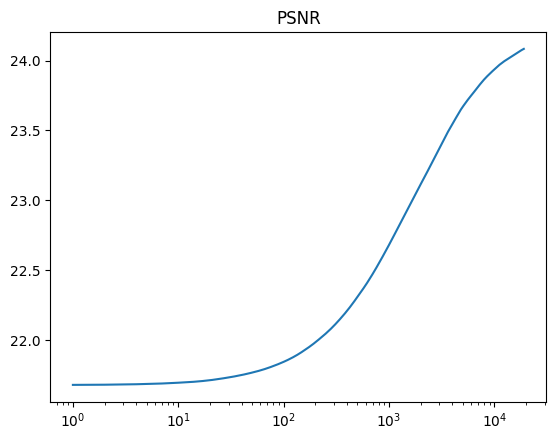

In [13]:
res = img_torch - x

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
ax[0].set_title(f"Clean Image (Reg Cost {model.cost(mu*img_torch)[0].item():.1f})")
im = ax[0].imshow(img_torch.detach().cpu().squeeze(), cmap="gray")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].set_title(f"Blurry Image (Reg Cost {model.cost(mu*img_torch_blurry)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(img_torch_blurry, img_torch).item():.2f}))")
im = ax[1].imshow(img_torch_blurry.detach().cpu().squeeze(), cmap="gray")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].set_title(f"Deblurred Image MAP (Regularization Cost {model.cost(mu*x)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(x, img_torch).item():.2f})")
im = ax[2].imshow(x.detach().cpu().squeeze(), cmap="gray")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_yticks([])
ax[2].set_xticks([])

ax[3].set_title(f"Residual (Regularization Cost {model.cost(mu*res)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(res, img_torch).item():.2f})")
im = ax[3].imshow(res.detach().cpu().squeeze(), cmap="gray")
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[3].set_yticks([])
ax[3].set_xticks([])

fig, ax = plt.subplots()
ax.set_title("log pi")
ax.plot(np.arange(1,len(logpi_eval)+1), logpi_eval)

fig, ax = plt.subplots()
ax.set_title(f"Deblurred Image MMSE (Regularization Cost {model.cost(mu*current_mean)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(current_mean, img_torch).item():.2f})")
ax.imshow(current_mean.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax.set_yticks([])
ax.set_xticks([])

fig, ax = plt.subplots()
ax.set_title(f"Deblurred Image MAP (Regularization Cost {model.cost(mu*x)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(x, img_torch).item():.2f})")
ax.imshow(x.detach().cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
ax.set_yticks([])
ax.set_xticks([])

fig, ax = plt.subplots()
ax.set_title(f"Deblurred Image VAR")
ax.imshow(current_var, cmap="gray")
ax.set_yticks([])
ax.set_xticks([])


luq.utils.autocor_plots(MC_X, current_var, "ULA", nLags=20)

fig, ax = plt.subplots()
ax.set_title("SSIM")
ax.semilogx(np.arange(1,len(ssim_values)+1), ssim_values)

fig, ax = plt.subplots()
ax.set_title("PSNR")
ax.semilogx(np.arange(1,len(psnr_values)+1), psnr_values)



plt.show()